# Creating the dataset

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

## With SPARC

### Loading the two samples

In [30]:
# Sample from table 2 : http://astroweb.cwru.edu/SPARC/ (for the velocity curves)

files = 'samples/rotmod_LTG/*.dat'
data = glob(files)
print("{} galaxies found".format(len(data)))

# Sample from table 1 : http://astroweb.cwru.edu/SPARC/ (for the luminosities [3.6] and effective radii)

df = pd.read_csv('samples/table1.csv')

175 galaxies found


### Useful functions

In [31]:
def finding_index(name):
    return data.index('./rotmod_LTG/' + name + '_rotmod.dat')
i = finding_index('CamB')

def finding_name(galaxy):
    return galaxy.name

### Merging the two data samples and calculating stellar masses and dark matter fraction

In [32]:
# Parameters in http://astroweb.cwru.edu/SPARC/

gammadisk = 0.5
gammabul = 0.7


# Calculating the stellar masses assuming M/L ratio is equal to 0.5 (Lelli 2016)

M = 0.5*df['L3_6']*10**9

class galaxy():
    def __init__(self, i):
        # Constructor method to initialize a galaxy object with index i
        self.index = i 
        # Index of the galaxy
        self.name = data[i].split('/')[-1].split('_')[0]
        # Extracting the name of the galaxy from the data file path
        self.radius = np.loadtxt(data[i])[:, 0]
        # Loading radius data from the data file
        self.Vobs = np.loadtxt(data[i])[:, 1]
        # Loading observed velocity data from the data file
        self.errV = np.loadtxt(data[i])[:, 2]
        # Loading error in velocity data from the data file
        self.Vgas = np.loadtxt(data[i])[:, 3]
        # Loading gas velocity data from the data file
        self.Vdisk = np.loadtxt(data[i])[:, 4]
        # Loading disk velocity data from the data file
        self.Vbul = np.loadtxt(data[i])[:, 5]
        # Loading bulge velocity data from the data file
        self.SBdisk = np.loadtxt(data[i])[:, 6]
        # Loading disk surface brightness data from the data file
        self.SBbul = np.loadtxt(data[i])[:, 7]
        # Loading bulge surface brightness data from the data file
        self.Vbar = None
        # Initializing attribute for baryons velocity
        self.fDM = None
        # Initializing attribute for dark matter fraction
        self.stellarmass = None
        # Initializing attribute for stellar mass
        self.effRad = None
        # Initializing attribute for effective radius

    def add_Vbar(self):
        # Method to calculate the velocity of the baryons
        Vbar = np.sqrt(abs(self.Vgas) * self.Vgas + gammadisk * abs(self.Vdisk) * self.Vdisk + gammabul * abs(self.Vbul) * self.Vbul)
        # Calculating the velocity of the baryons
        self.Vbar = Vbar
        return 1
        
    def add_fDM(self):
        # Method to calculate dark matter fraction
        if self.Vbar == None:
           self.add_Vbar() 
        # Checking if the velocity of the baryons has been calculated, if not, calculate it
        fDM = (self.Vobs**2 - self.Vbar**2) / (self.Vobs**2)
        # Calculating dark matter fraction
        self.fDM = fDM
        # Assigning calculated dark matter fraction to attribute
        return 1
        
    def isintwo(self):
        # Method to check if galaxy is in the two data samples
        if len(np.where(df['Name'] == self.name)[0]) != 0:
            return 1
        else:
            return 0
            
    def add_stellarmass(self):
        # Method to add stellar mass data (in solar mass)
        if len(np.where(df['Name'] == self.name)[0]) != 0:
            # Checking if galaxy is in the two data samples
            Mass = M[np.where(df['Name'] == self.name)[0][0]]
            # Getting stellar mass from pre-calculated data
            self.stellarmass = Mass
            # Assigning stellar mass to attribute
        return 1
        
    def add_effRad(self):
        # Method to add effective radius data (in kpc)
        if len(np.where(df['Name'] == self.name)[0]) != 0:
            # Checking if galaxy is in the two data samples
            R = df['Reff'][np.where(df['Name'] == self.name)[0][0]]
            # Getting effective radius
            self.effRad = R
            # Assigning effective radius to attribute
        return 1


# Testing

firstgal = galaxy(i)

firstgal.add_fDM()
firstgal.add_stellarmass()
firstgal.add_effRad()


print(firstgal.fDM, firstgal.stellarmass)

[-1.64913765 -1.68159834 -1.18247184 -0.77882072 -0.42995455 -0.1259083
  0.12626383  0.32082129  0.60668758] 37500000.0


### Reproducing plots from Lelli 2016 for testing


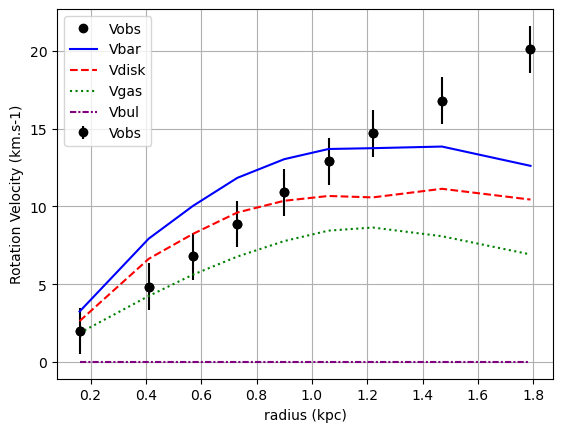

In [33]:
errV = firstgal.errV 

plt.errorbar(firstgal.radius, firstgal.Vobs, yerr=errV, fmt='o', label='Vobs', color='black')

plt.plot(firstgal.radius, firstgal.Vobs,'o', label='Vobs', color = 'black')
plt.plot(firstgal.radius, firstgal.Vbar, label='Vbar', color='blue')
plt.plot(firstgal.radius, firstgal.Vdisk * 0.7,linestyle= 'dashed', label='Vdisk', color = 'red')
plt.plot(firstgal.radius, firstgal.Vgas, linestyle = 'dotted',label='Vgas', color = 'green')
plt.plot(firstgal.radius, firstgal.Vbul *.85, linestyle =(0, (3, 1, 1, 1)), label='Vbul', color = 'purple')
plt.xlabel('radius (kpc)')
plt.ylabel('Rotation Velocity (km.s-1)')
#plt.ylim([0, 300])
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('SPARC_MassModel/'+finding_name(firstgal)+'.png')

### Making the final csv file

In [34]:
import csv
import numpy as np

# Open a CSV file for writing
with open('dataset/SPARC.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')

    # Write the name line and the unit line
    writer.writerow(["Name", "M*", "Reff", "fDM(Reff)", "sigma_fdm(Reff)", "fDM", "sigma_fdm", "Radius"])
    writer.writerow(["(SDSS)", "[Msun]", "[kpc]", "None", "None", "None", "None", "[kpc]"])

    # Loop through each element of data
    for i in range(len(data)):
        firstgal = galaxy(i)
        if firstgal.isintwo():
            firstgal.add_fDM()
            firstgal.add_stellarmass()
            firstgal.add_effRad()

            # Extracting necessary data
            name = firstgal.name
            errV = firstgal.errV
            Mass = '{:.2e}'.format(firstgal.stellarmass)
            effRad = firstgal.effRad
            rad = firstgal.radius
            rad_str = ", ".join(map(str, rad))  # Convert the NumPy array to a string
            fDM = firstgal.fDM
            fDM_str = ", ".join(map(str, fDM))
            fDMeff = np.interp(effRad, rad, firstgal.fDM)
            sigma_fdm = np.sqrt((2 * firstgal.Vbar**2 / firstgal.Vobs**3 * errV)**2)
            sigma_fdm_str = ", ".join(map(str, sigma_fdm))
            sigma_fdmeff = np.sqrt((2 * np.interp(effRad, rad, firstgal.Vbar)**2 / np.interp(effRad, rad, firstgal.Vobs)**3 * np.interp(effRad, rad, errV))**2)

            # Write the data to the CSV file with commas as separators
            writer.writerow([name, Mass, effRad, fDMeff, sigma_fdmeff , fDM_str, sigma_fdm_str, rad_str])
            
# Read the CSV file into a DataFrame
sparc = pd.read_csv('dataset/SPARC.csv')
# Test
print(sparc['fDM'].iloc[1])


0.3641071029577853, 0.41844809507631825, 0.43746364776234553, 0.3983703110860865, 0.38245180564413267, 0.39030169116612046, 0.4311160355548469, 0.4519368566792862


## With Bezanson 2015

### Loading the data

In [35]:
df = pd.read_csv('samples/bezanson.csv')

### Selecting and converting data into the correct units

In [40]:
selection = df[['sig_Re', 'Re', 'logM']]
kpc = 3.085e16*1e3

# The velocities dispersion
veldisp = df['sig_Re']*1e3
# The radii
r = df['Re']*kpc
# The stellar masses
M = 10**df['logM']*2e30

### Constants

In [42]:
G = 6.67e-11
K = 5
#ref for K: http://dx.doi.org/10.1111/j.1365-2966.2005.09981.x

### Calculating the fraction of dark matter

In [ ]:
f = 1 - (M*G)/(veldisp**2*r*K)

### Making the final csv file

In [43]:
# Writing the data into a CSV file
with open('dataset/BEZANSON15.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow(["Name", "M*", "Reff", "fDM(Reff)", "sigma_fdm(Reff)"])
    writer.writerow(["None", "[Msun]", "[kpc]", "None", "None"])

    # Looping through each element of the DataFrame
    for i in range(len(df)):
        name = df['ID'][i]
        Mass = 10**df['logM'][i]
        effRad = r[i] / kpc
        fDMeff = f[i]
        sigma_fdmeff = df['e_sig_Re'][i] * abs(2 * (Mass * 2e30 * G) / (veldisp[i]**3 * effRad * kpc * K))
        # Writing the data into the CSV file
        writer.writerow([name, Mass, effRad, fDMeff, sigma_fdmeff])
        
# Reading the CSV file into a DataFrame
bezanson = pd.read_csv('dataset/BEZANSON15.csv')
bezanson

,Name,M*,Reff,fDM(Reff),sigma_fdm(Reff)
0,NaN,[Msun],[kpc],NaN,NaN
1,C1971,91201083935.59116,4.4,0.597364,0.000031
2,C2335,13489628825.916561,0.8,0.286870,0.000060
3,C3382,41686938347.03346,5.9,0.735521,0.000024
4,C3420,67608297539.19819,2.1,0.571815,0.000054
...,...,...,...,...,...
96,U40638,70794578438.41373,3.9,0.056620,0.000102
97,U40998,17782794100.38923,2.3,0.259107,0.000109
98,U41037,24547089156.850334,1.6,0.576490,0.000048
99,U41224,10000000000.0,1.0,0.511092,0.000074


## With Cappellari

### Loading the two samples

In [46]:
capXV=np.loadtxt('samples/CappellariXV.txt',  usecols=np.arange(1, 15))
capXX= np.loadtxt('samples/CappellariXX.txt', usecols=np.arange(1, 5))


### Calculating stellar masses and DM fraction

In [47]:
logML = capXX[:,-2]
logL = capXV[:,-1]
M = 10**(logML+logL)
fDM = capXX[:,-3]

### Making the final csv file

In [49]:
# Writing the data into a CSV file
with open('dataset/CAPPELLARI13.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow(["Name", "M*", "fDM(Reff)", "sigma_fdm(Reff)"])
    writer.writerow(["None", "[Msun]", "None", "None"])

    # Looping through each element of the data
    for i in range(len(capXV)):
        name = capXV[i,0]
        Mass = M[i]

        fDMeff = fDM[i]
        sigma_fdmeff = 0 #no errors provided
        # Writing the data into the CSV file
        writer.writerow([name, Mass, fDMeff, sigma_fdmeff])
        
# Reading the CSV file into a DataFrame
cappellari = pd.read_csv('dataset/CAPPELLARI13.csv')
cappellari

,Name,M*,fDM(Reff),sigma_fdm(Reff)
0,NaN,[Msun],NaN,NaN
1,1.879,9885530946.56941,0.12,0.0
2,1.996,12473835142.429434,0.24,0.0
3,1.806,13835663789.71781,0.20,0.0
4,2.108,33884415613.920208,0.11,0.0
...,...,...,...,...
254,1.781,7063175542.629622,0.00,0.0
255,2.125,31117163371.0602,0.25,0.0
256,1.984,12078138351.067772,0.50,0.0
257,2.105,27925438412.373363,0.00,0.0
